In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
import xarray as xr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

warnings.filterwarnings("ignore",message='invalid value encountered in less_equal')

%matplotlib inline

In [4]:
savePath = '/Users/danstechman/GoogleDrive/School/Research/PECAN/Microphysics/plots/vertical_profiles'
fType = 'pdf'


# flights = ['20150617','20150620','20150701','20150702','20150706','20150709']
flights = ['20150620']

In [5]:
sTot = 1
ntChange = np.zeros((sTot,1))
twcChange = np.zeros((sTot,1))
tempLapse = np.zeros((sTot,1))
iSprl = 0
for flight in flights:
    print('Working on {}...'.format(flight))

    cipFile = '/Users/danstechman/GoogleDrive/PECAN-Data/mp-data/' + flight + '/' + flight + '_CIPfit-spirals-10s1sAvg.nc'
    pecanPrmF = '/Users/danstechman/GoogleDrive/PECAN-Data/' + flight + '_PECANparams.nc'
    flFile = '/Users/danstechman/GoogleDrive/PECAN-Data/FlightLevelData/Processed/' + flight + '_FltLvl_Processed.nc'
    
    # Pull out any PECAN parameters
    pecanPrms = xr.open_dataset(pecanPrmF,decode_times=False)
    mlBotTemp = pecanPrms.mlBotTemp.data
    mlTopTemp = pecanPrms.mlTopTemp.data
    startT = pecanPrms.startT.data
    endT = pecanPrms.endT.data
    
    # Pull out FL data
    flData = xr.open_dataset(flFile,decode_times=False)
    timeSecs_FL = flData.time_secs_FL.data
    fl_tempC = flData.TA.data
    fl_rh = flData.RH_hybrid.data
    fl_alt_mMSL = flData.Alt.data
    fl_windSpd_ms = flData.windSpd.data

    # Pull out any global variables/attributes from the netcdf file
    cipData_root = xr.open_dataset(cipFile)
    sprlZone = str(cipData_root.sprlZone.data,'utf-8')
    mcsType = str(cipData_root.mcsType.data,'utf-8')
    numSprls = len(sprlZone)
    
    
    # Loop over each spiral for the current flight
#     for ix in np.arange(0,numSprls):
    for ix in [1]:
        print('\tAnalyzing Spiral {}'.format(ix+1))
        
         # Get start and end indices for FL variables within current spiral
        strtMatch = min(timeSecs_FL, key=lambda x: abs(x - startT[ix]))
        endMatch = min(timeSecs_FL, key=lambda x: abs(x - endT[ix]))
        flStrtIx = np.squeeze(np.where(timeSecs_FL == strtMatch))
        flEndIx = np.squeeze(np.where(timeSecs_FL == endMatch))
        
        flRHsprl = fl_rh[flStrtIx:flEndIx]
        flAltSprl = fl_alt_mMSL[flStrtIx:flEndIx]
        flTempCsprl = fl_tempC[flStrtIx:flEndIx]
        
        # Open the group associated with the current spiral
        cipData = xr.open_dataset(cipFile,group='spiral_' + str(ix+1))

        Nt = cipData.cipNt_hybrid_igf.data
        twc = cipData.cipTWC_hybrid_igf_mlr.data
        tempC_10s = cipData.tempC_10s.data
        cipTime_10s = cipData.cipTsec_10s.data
        
        twc[twc == 0] = np.nan
        Nt[Nt == 0] = np.nan
        
        # Get index of temp nearest 0 deg C for CIP variables
        negTmatch_cip = min(tempC_10s, key=lambda x: abs(x - 0.0))
        negTmatch_cipIx = np.squeeze(np.where(tempC_10s == negTmatch_cip))
        if tempC_10s[0] > tempC_10s[-1]:
            sprlUp = True
            cipTempCsprl = tempC_10s[negTmatch_cipIx:]
            cipNtSprl = Nt[negTmatch_cipIx:]
            cipTWCsprl = twc[negTmatch_cipIx:]
            
#             tempLapse[iSprl] = (flTempCsprl[-1] - flTempCsprl[0])/((flAltSprl[-1] - flAltSprl[0])/1000)
        else:
            sprlUp = False
            cipTempCsprl = tempC_10s[:negTmatch_cipIx]
            cipNtSprl = Nt[:negTmatch_cipIx]
            cipTWCsprl = twc[:negTmatch_cipIx]
            
#             tempLapse[iSprl] = (flTempCsprl[0] - flTempCsprl[-1])/((flAltSprl[0] - flAltSprl[-1])/1000)

        fitIgnrIx = []
        if flight == '20150617':
            if ix == 0:
                fitIgnrIx = np.where(cipNtSprl < 5e-4)
            if ix == 2:
                fitIgnrIx = np.where(cipNtSprl < 5e-4)
        if flight == '20150706':
            if ix == 0:
#                 fitIgnrIx = np.where((cipTempCsprl < -8) | (cipTempCsprl > -5))
#                 fitIgnrIx = np.where(cipTempCsprl < -5)
                fitIgnrIx = np.where(cipTempCsprl < -8)
#             if ix == 1:
#                 fitIgnrIx = np.where(cipNtSprl < 5e-4)
        if flight == '20150709':
            if ix == 0:
                fitIgnrIx = np.where(cipTempCsprl > -6)
                
        if fitIgnrIx:
            cipNtSprl[fitIgnrIx] = np.nan
            cipTWCsprl[fitIgnrIx] = np.nan
            
        finiteIx = np.isfinite(np.log10(cipNtSprl)) & np.isfinite(cipTempCsprl)
        pf_Nt = np.poly1d(np.polyfit(cipTempCsprl[finiteIx],np.log10(cipNtSprl[finiteIx]),  1))
        ntChange[iSprl] = 1 - (10**pf_Nt(-6)/10**pf_Nt(-5)) # 1 deg C change percentage
        
        finiteIx = np.isfinite(np.log10(cipTWCsprl)) & np.isfinite(cipTempCsprl)
        pf_twc = np.poly1d(np.polyfit(cipTempCsprl[finiteIx],np.log10(cipTWCsprl[finiteIx]),  1))
        twcChange[iSprl] = 1 - (10**pf_twc(-6)/10**pf_twc(-5)) # 1 deg C change percentage
        
        finiteIx = np.isfinite(flAltSprl) & np.isfinite(flTempCsprl)
        pf_temp = np.poly1d(np.polyfit(flAltSprl[finiteIx]/1000,flTempCsprl[finiteIx],  1))
        tempLapse[iSprl] = pf_temp(6) - pf_temp(5)
        
#         finiteIx = np.isfinite(flAltSprl) & np.isfinite(flTempCsprl)
#         m_temp, b_temp = np.polyfit(flTempCsprl[finiteIx], flAltSprl[finiteIx]/1000, 1)
#         tempFit = m_temp*flTempCsprl + b_temp
#         tempLapse[iSprl] = ((6 - b_temp)/m_temp) - ((5 - b_temp)/m_temp)
        
        iSprl += 1
        
print(ntChange[0][0]*100)
print(twcChange[0][0]*100)

Working on 20150706...
	Analyzing Spiral 2
17.926551740473972
6.244524378263461


In [ ]:
tempLapse

In [ ]:
# np.savetxt('/Users/danstechman/Desktop/dTWCdT.csv', twcChange, delimiter=',')

Text(0.5,1,'20150709 - Spiral 1')

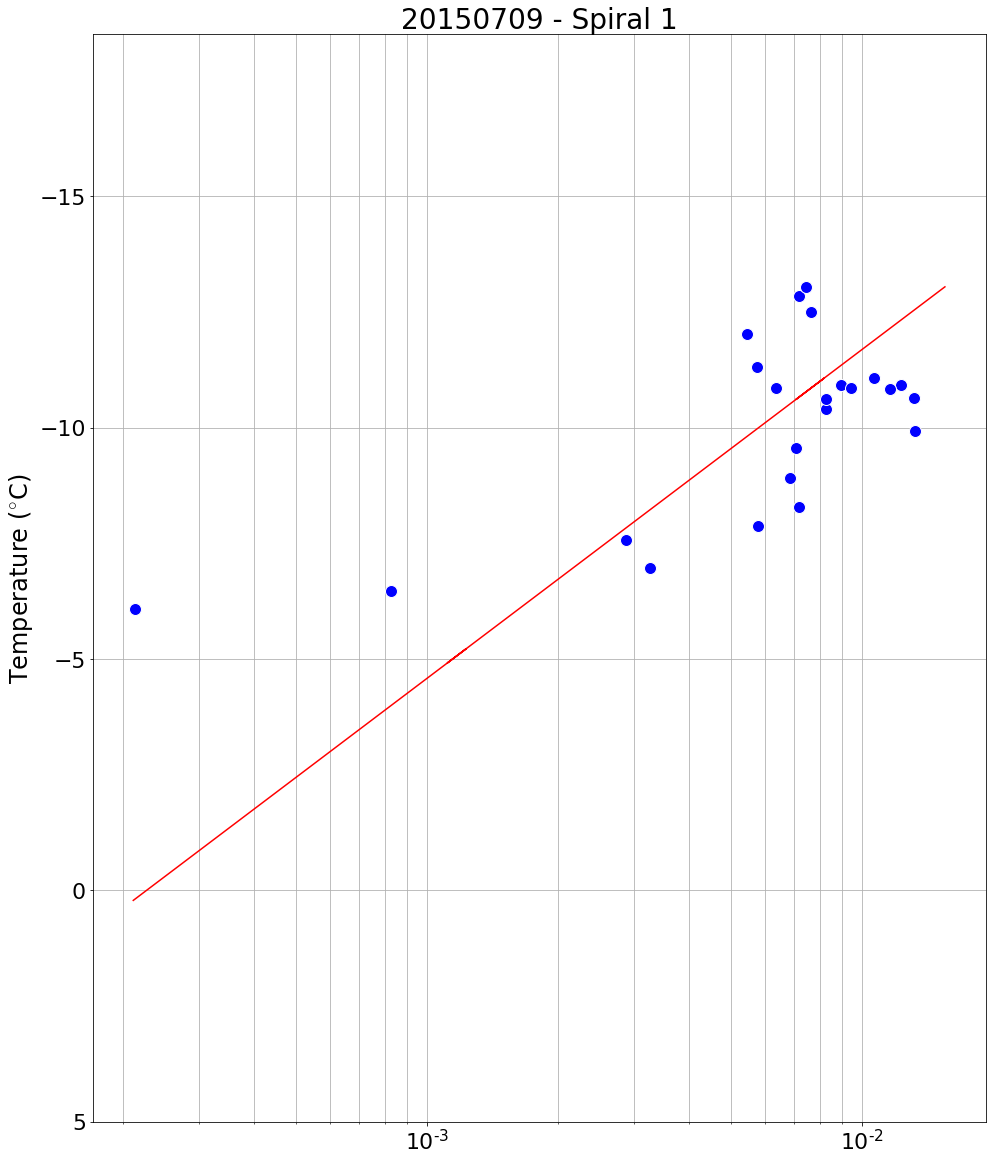

In [6]:
fig, ax = plt.subplots(figsize=(16,20))

ax.plot(cipNtSprl,cipTempCsprl,'bo',markeredgecolor='white',markeredgewidth=1,markersize=12)
ax.plot(10**(pf_Nt(cipTempCsprl)),cipTempCsprl,'r-')
# ax.plot(cipTWCsprl,cipTempCsprl,'bo',markeredgecolor='white',markeredgewidth=1,markersize=12)
# ax.plot(10**(pf_twc(cipTempCsprl)),cipTempCsprl,'r-')

ax.set_ylim(-18.5,5)
ax.set_xscale('log',nonposx='mask')
ax.invert_yaxis()
ax.set_ylabel('Temperature ($^{\circ}$C)',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.grid(which='both')
# ax.legend(loc='lower left',fontsize=18)
ax.set_title('{} - Spiral {}'.format(flight,ix+1),fontsize=28)